In [16]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import IterableDataset, DataLoader
from matplotlib import pyplot as plt
from typing import Tuple, Optional, Any
import math
from torch import Tensor
from einops import rearrange
from diffusers import DDPMScheduler
from torchvision import transforms, datasets
from tqdm import tqdm
from IPython.display import clear_output
import einops
from torch.utils.data.dataset import Dataset
from dataclasses import dataclass
from typing import List, Union, Dict, Any, Optional, BinaryIO
from PIL import Image, ImageColor, ImageDraw, ImageFont
import abc  # Abstract base class
import numpy as np
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import DDPMScheduler, DDPMPipeline
from diffusers.models.unets.unet_2d_condition import UNet2DConditionModel
from diffusers import DDPMScheduler, DDPMPipeline
from diffusers import DDPMScheduler, DDPMPipeline
from datasets import load_dataset
import requests
from io import BytesIO


In [17]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet2DConditionModel(
    sample_size=256,  # input resolution
    in_channels=4,  # latent channels (usually 4 if using VAE)
    out_channels=4,  # same as in_channels for DDPM
    down_block_types=[
        "CrossAttnDownBlock2D",  # uses text-conditioning attention
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "DownBlock2D",           # last block can omit attention
    ],
    up_block_types=[
        "UpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
    ],
    block_out_channels=[320, 640, 1280, 1280],  # Wide receptive fields and strong representations
    layers_per_block=2,
    cross_attention_dim=768,  # CLIP text embedding size (ViT-B/32)
    attention_head_dim=8,
    norm_num_groups=32
)
model = model.to(device)


In [18]:
# vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Freeze VAE and text encoder
# vae.requires_grad_(False)
## set requires_grad_ to true so that the text_enocder aka CLIP model is also trained.
text_encoder.requires_grad_(False)
# tokenizer.requires_grad_(False)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [19]:
TOKENIZER_MAX_LENGTH = 77
example_prompt = ["a photo of a golden retriever wearing sunglasses"]
text_input = tokenizer(example_prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
text_encoder(text_input.input_ids.to(device))[0].shape

## the following output is the size of the text embedding for one text prompt.

torch.Size([1, 77, 512])

In [20]:
num_of_params = sum([p.numel() for p in model.parameters()])
print("Number of trainable parameters in the model: " + str(f"{num_of_params:,}"))

Number of trainable parameters in the model: 859,520,964


In [21]:
class LaionStreamDataset(IterableDataset):
    def __init__(self, transform=None, max_items=None):
        self.dataset = load_dataset("laion/laion2B-en", streaming=True, split="train")
        self.transform = transform
        self.max_items = max_items

    def __iter__(self):
        count = 0
        for example in self.dataset:
            try:
                url = example["url"]
                caption = example["caption"]

                response = requests.get(url, timeout=5)
                image = Image.open(BytesIO(response.content)).convert("RGB")

                if self.transform:
                    image = self.transform(image)

                yield image, caption

                count += 1
                if self.max_items and count >= self.max_items:
                    break

            except Exception as e:
                print(f"Skipping due to error: {e}, url: {url}")
                continue

In [ ]:
# Define transforms (resize, normalize, convert to tensor)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Create dataset and dataloader
dataset = LaionStreamDataset(transform=image_transform, max_items=100)  # change limit as needed
train_dataloader = DataLoader(dataset, batch_size=8)

# noise sched
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")


Skipping due to error: cannot identify image file <_io.BytesIO object at 0x000002284E66B970>, url: https://www.picclickimg.com/d/l400/pict/333262346250_/Brent-Payne-Brent-Payne-1999-Self-Released-Country.jpg
Skipping due to error: cannot identify image file <_io.BytesIO object at 0x0000022848C638D0>, url: https://d1251d0o0760fi.cloudfront.net/catalog/product/1/4/14k-gold-diamond-engagement-ring-264-ct-p-64.jpg
Skipping due to error: cannot identify image file <_io.BytesIO object at 0x00000228487A07C0>, url: https://commeny95.fr/wp-content/uploads/2019/02/affiche-info-inscription-maternelle-250x250.jpg
Skipping due to error: broken data stream when reading image file, url: https://render.fineartamerica.com/images/rendered/wall-view/medium/room003/print-poster/images-medium/spring-day-nicole-devita.jpg?printWidth=8&printHeight=10
Skipping due to error: cannot identify image file <_io.BytesIO object at 0x000002277E3DE890>, url: https://cdn.myshoptet.com/usr/obchod.salononline.cz/user/shop

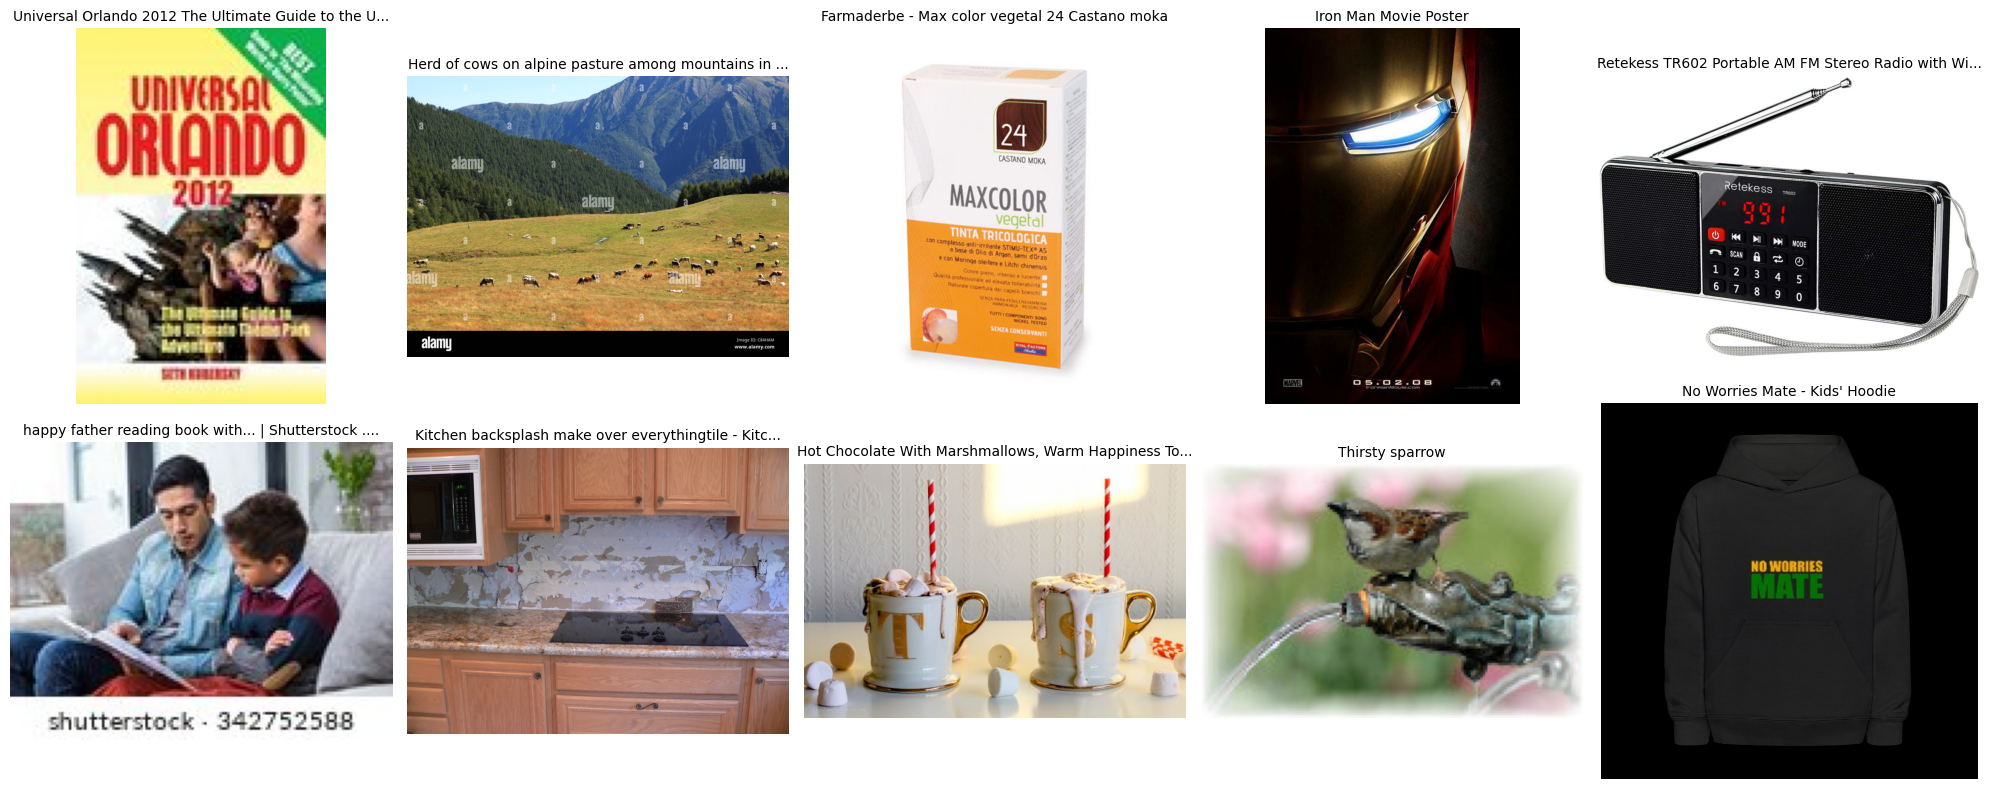

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

count = 0
for image, caption in dataset:
    axes[count].imshow(image)
    axes[count].set_title(caption[:50] + "..." if len(caption) > 50 else caption, fontsize=10)
    axes[count].axis("off")

    count += 1
    if count == 10:
        break

plt.tight_layout()
plt.show()

In [ ]:
# Training parameters
# num_epochs = 100
num_epochs = 1
# learning_rate = 1e-4
learning_rate = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
steps= 0

# Training loop
for epoch in range(num_epochs):
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, captions = batch
        images = images.to(device)

        # Encode images
        # latents = vae.encode(images).latent_dist.sample()
        # latents = latents * 0.18215 ## vae scale factor
        latents = images

        # Encode text
        text_input = tokenizer(captions, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

        # Add noise to latents
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Predict noise
        noise_pred = model(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample

        # Calculate loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)

        steps = steps+1
        if (steps % 25 == 0):
            print(f"steps {steps}, Loss: {loss.item()}")

        # Backpropagate and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

NameError: name 'unet' is not defined

/tmp/ipython-input-13-516014115.py:18: FutureWarning: Accessing config attribute `in_channels` directly via 'CustomUNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'CustomUNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, unet.in_channels, 28, 28)).to(device)
100%|██████████| 50/50 [00:02<00:00, 24.90it/s]


torch.Size([1, 1, 28, 28])


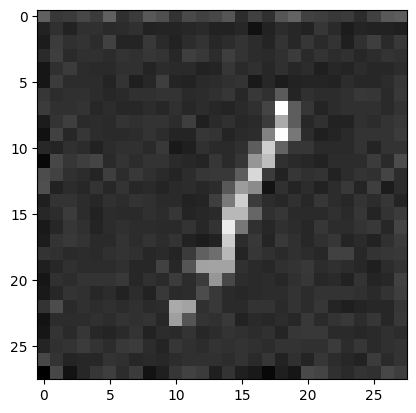

In [ ]:
# Set models to evaluation mode
# vae.eval()
text_encoder.eval()
model.eval()

# Inference parameters
num_inference_steps = 50
# guidance_scale = 100

@torch.no_grad()
def generate_image(prompt):
    # Tokenize and encode the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Initialize latents / create noisy image.
    torch.manual_seed(422)  # Set the seed
    latents = torch.randn((1, model.in_channels, 28, 28)).to(device)

    # Denoise scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    # Denoising loop
    for t in tqdm(scheduler.timesteps):
        # Prepare latent model input
        latent_model_input = scheduler.scale_model_input(latents, t)

        # Predict noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # # Decode latents to image
    # latents = 1 / 0.18215 * latents
    # image = vae.decode(latents).sample
    image=latents
    print (image.shape)
    # Post-process image ## i.e reverse the normalization
    image = (image / 2 + 0.5).clamp(0, 1)
    # image = image.cpu().permute(0, 2, 3, 1).numpy()
    # image = (image * 255).round().astype("uint8")
    return image

# Generate an image
prompt = "A handwritten digit 4"
generated_image = generate_image(prompt)

# Display or save the image
image = generated_image[0]  # Remove the extra dimension
image = image.squeeze(0)
image = image.detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
image = (image * 255).round().astype("uint8")
import matplotlib.pyplot as plt

# Assuming generated_image is the tensor you want to view
# image = generated_image[0].detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
plt.imshow(image, cmap='gray')  # Display as grayscale image
plt.show()

In [ ]:
## save unet and text_encoder
# Save the trained model
# torch.save(unet.state_dict(), "./unet.pth")


/tmp/ipython-input-15-133456894.py:25: FutureWarning: Accessing config attribute `in_channels` directly via 'CustomUNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'CustomUNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((num_images, unet.in_channels, 28, 28)).to(device)
100%|██████████| 50/50 [00:02<00:00, 20.28it/s]

torch.Size([1, 1, 28, 28])


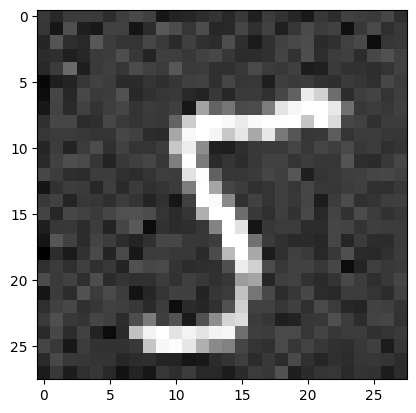

In [ ]:
# Set models to evaluation mode
# vae.eval()
# text_encoder.eval()
unet.eval()

# Inference parameters
num_inference_steps = 50
guidance_scale = 8

@torch.no_grad()
def generate_image(prompt, num_images=1):
    # Tokenize and encode the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Prepare unconditioned embeddings for classifier free guidance
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * num_images, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # Concatenate text embeddings with unconditional embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Initialize latents
    latents = torch.randn((num_images, unet.in_channels, 28, 28)).to(device)

    # Denoise scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    for t in tqdm(scheduler.timesteps):
        # Expand latents for classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        # Predict noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # # Decode latents to image
    # latents = 1 / 0.18215 * latents
    # image = vae.decode(latents).sample
    image=latents
    print (image.shape)
    # Post-process image
    image = (image / 2 + 0.5).clamp(0, 1)
    # image = image.cpu().permute(0, 2, 3, 1).numpy()
    # image = (image * 255).round().astype("uint8")
    return image

# Generate an image
prompt = "A handwritten digit 5"
generated_images = generate_image(prompt)

# Display or save the image
image = generated_images[0]  # Remove the extra dimension
image = image.squeeze(0)
image = image.detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
image = (image * 255).round().astype("uint8")
import matplotlib.pyplot as plt

# Assuming generated_image is the tensor you want to view
# image = generated_image[0].detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
plt.imshow(image, cmap='gray')  # Display as grayscale image
plt.show()


/tmp/ipython-input-15-133456894.py:25: FutureWarning: Accessing config attribute `in_channels` directly via 'CustomUNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'CustomUNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((num_images, unet.in_channels, 28, 28)).to(device)
100%|██████████| 50/50 [00:01<00:00, 31.33it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 29.71it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:02<00:00, 24.98it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 32.17it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 31.99it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 32.50it/s]


torch.Size([1, 1, 28, 28])


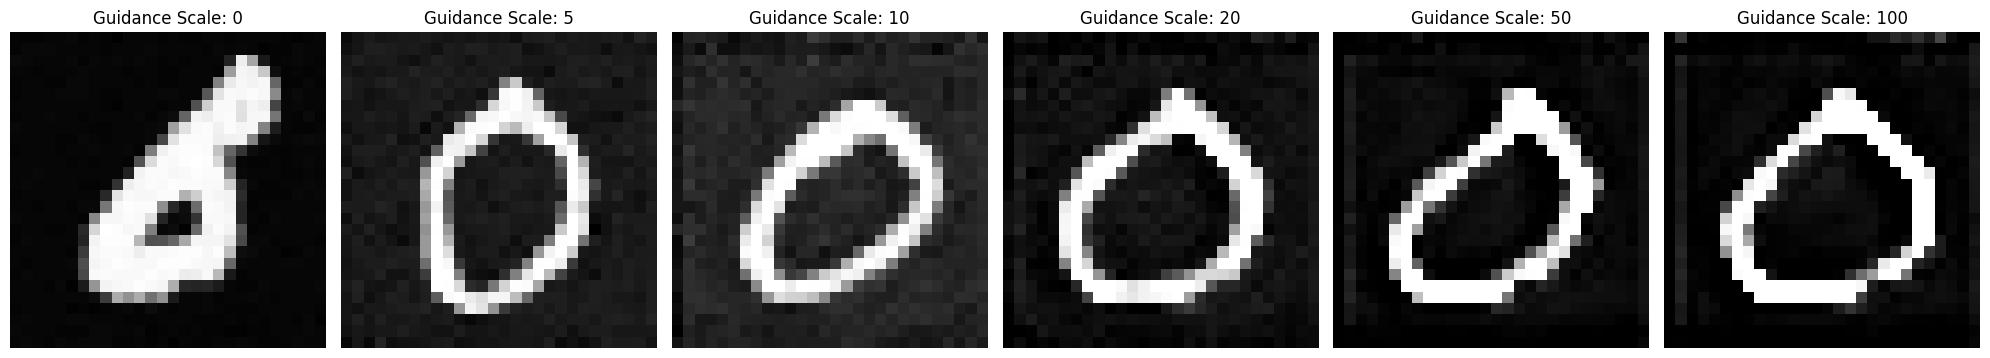

In [ ]:
# Define the guidance scale values
guidance_scales = [0, 5, 10, 20, 50, 100]

# Initialize a figure with a grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=len(guidance_scales), figsize=(20, 4))

# Generate an image for each guidance scale value
for i, guidance_scale in enumerate(guidance_scales):
    # Set the guidance scale
    # global guidance_scale
    # guidance_scale = guidance_scale

    # Generate an image
    prompt = "A handwritten digit 0"
    generated_image = generate_image(prompt)

    # Display or save the image
    image = generated_image[0]  # Remove the extra dimension
    image = image.squeeze(0)
    image = image.detach().cpu().numpy()  # Remove batch dimension
    image = (image * 255).round().astype("uint8")

    # Display the image in the current subplot
    axs[i].imshow(image, cmap='gray')  # Display as grayscale image
    axs[i].set_title(f'Guidance Scale: {guidance_scale}')
    axs[i].axis('off')

# Layout so plots do not overlap
fig.tight_layout()

# Display the plot
plt.show()